In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import hsv
from matplotlib.cm import Accent
from matplotlib.cm import Paired

In [2]:
plt.style.use('ggplot')

# Load data

In [3]:
mhc_fil = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp3_MHC/processed/tmp/aligned_data/v2.analysed.tsv"
tcr_fil = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp3_TCR/processed/cellranger_out/TCR_VDJ/outs/all_contig_annotations.csv"
fig_dir = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/plots/"
barcode_id_fil = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp3_MHC/barcode_library/annotations.xlsx"

In [4]:
tcr_filtered_gems_dir = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp3_TCR/processed/gem_filtration_lists/"

In [5]:
mhc_df = pd.read_csv(mhc_fil, sep = "\t", names = ("align_object", "read_id", "align_start", "align_end", "align_score1", "align_score2", "obj_len", "obj_id", "align_len", "prev_dist", "next_dist", "read_len", "min_dist"))
tcr_df = pd.read_csv(tcr_fil)

In [6]:
barcode_ids = pd.ExcelFile(barcode_id_fil)
mhc_barcode_ids = barcode_ids.parse('MHC').Barcode.values
cd8_barcode_ids = barcode_ids.parse('CD8').Barcode.values

# Modify MHC dataframe

In [7]:
mhc_df["gem"] = mhc_df["read_id"].str.split("BX:Z:", n = 1, expand = True)[1]

# Assess data

In [8]:
mhc_df.dtypes

align_object     object
read_id          object
align_start     float64
align_end       float64
align_score1    float64
align_score2    float64
obj_len         float64
obj_id           object
align_len       float64
prev_dist       float64
next_dist       float64
read_len          int64
min_dist        float64
gem              object
dtype: object

In [9]:
mhc_df.head(n=8)

,align_object,read_id,align_start,align_end,align_score1,align_score2,obj_len,obj_id,align_len,prev_dist,next_dist,read_len,min_dist,gem
0,SAMPLE,HBBAF:00130:00791 BX:Z:AAAGTAGGTGATAAGT-1,49.0,53.0,2.883852,2.348562,8.0,bc25mer_21627,5.0,48.0,-53.0,124,48.0,AAAGTAGGTGATAAGT-1
1,A_PRIM,HBBAF:00130:00791 BX:Z:AAAGTAGGTGATAAGT-1,1.0,6.0,-4.058228,NaN,6.0,NaN,6.0,-53.0,0.0,124,0.0,AAAGTAGGTGATAAGT-1
2,A_N6,HBBAF:00130:00791 BX:Z:AAAGTAGGTGATAAGT-1,7.0,12.0,NaN,NaN,6.0,NaN,NaN,0.0,0.0,124,0.0,AAAGTAGGTGATAAGT-1
3,A_OLIGO,HBBAF:00130:00791 BX:Z:AAAGTAGGTGATAAGT-1,13.0,37.0,49.749481,-0.140005,25.0,2OS-1-Oligo-A1064,25.0,0.0,0.0,124,0.0,AAAGTAGGTGATAAGT-1
4,ANNEAL,HBBAF:00130:00791 BX:Z:AAAGTAGGTGATAAGT-1,38.0,62.0,49.610130,NaN,25.0,NaN,25.0,0.0,0.0,124,0.0,AAAGTAGGTGATAAGT-1
5,B_OLIGO,HBBAF:00130:00791 BX:Z:AAAGTAGGTGATAAGT-1,63.0,87.0,49.698215,-0.265417,25.0,2OS-4-long-Oligo-B288,25.0,0.0,0.0,124,0.0,AAAGTAGGTGATAAGT-1
6,B_N6,HBBAF:00130:00791 BX:Z:AAAGTAGGTGATAAGT-1,88.0,93.0,NaN,NaN,6.0,NaN,NaN,0.0,0.0,124,0.0,AAAGTAGGTGATAAGT-1
7,B_PRIM,HBBAF:00130:00791 BX:Z:AAAGTAGGTGATAAGT-1,94.0,124.0,56.567516,NaN,32.0,NaN,31.0,0.0,0.0,124,0.0,AAAGTAGGTGATAAGT-1


## Assessment of number of aligned reads

In [10]:
len(mhc_df.read_id.unique())

26796

In [11]:
len(mhc_df[mhc_df.min_dist == 0].read_id.unique())

26796

## Assessment of minimum distance scores

In [ ]:
mhc_df[mhc_df.align_object == "SAMPLE"].min_dist.describe()

## Assessment of alignment scores

In [ ]:
x = mhc_df[mhc_df.align_object == "A_OLIGO"].align_score1
y = mhc_df[mhc_df.align_object == "A_OLIGO"].align_score2

plt.title("Alignemnt scores of oligo A")
plt.xlabel("Best alignment score")
plt.ylabel("Second best alignment score")
plt.plot(x, y, '.', color='#9e0142')

In [ ]:
x = mhc_df[mhc_df.align_object == "B_OLIGO"].align_score1
y = mhc_df[mhc_df.align_object == "B_OLIGO"].align_score2

plt.title("Alignemnt scores of oligo B")
plt.xlabel("Best alignment score")
plt.ylabel("Second best alignment score")
plt.plot(x, y, '.', , color='#9e0142')

# Write evaluation matrix

In [16]:
filtered_reads = 0
keep = 1

num_reads = len(mhc_df.read_id.unique())

evaluation_df = pd.DataFrame(np.zeros((num_reads, 3), dtype=np.int8),
                              columns = ['read_id', 'pass', 'mhc_barcode'])

for i, read in enumerate(mhc_df.read_id.unique()):
    #if i == num_reads:
    #    break
    
    sub_df = mhc_df[(mhc_df.read_id == read)] #  & (mhc_df.align_object != "SAMPLE")
    
    # Filter away reads that do not meet criteria
    #if any(sub_df[sub_df.align_object.isin(["A_OLIGO", "ANNEAL", "B_OLIGO", "B_N6", "B_PRIM"])].min_dist > 0):
    if any(sub_df.min_dist > 0):
        filtered_reads += 1
        keep = 0
    elif sub_df[sub_df.align_object == "A_OLIGO"].align_score1.values[0] < 0:
        filtered_reads += 1
        keep = 0
    elif sub_df[sub_df.align_object == "B_OLIGO"].align_score1.values[0] < 0:
        filtered_reads += 1
        keep = 0
    elif sub_df[sub_df.align_object == "A_OLIGO"].align_score1.values[0] < 2 * abs(sub_df[sub_df.align_object == "A_OLIGO"].align_score2.values[0]):
        filtered_reads += 1
        keep = 0
    elif sub_df[sub_df.align_object == "B_OLIGO"].align_score1.values[0] < 2 * abs(sub_df[sub_df.align_object == "B_OLIGO"].align_score2.values[0]):
        filtered_reads += 1
        keep = 0
        
    # Update the number of reads that support an MHC barcode in a GEM
    pmhc_barcode = sub_df[sub_df.align_object == "A_OLIGO"].obj_id.to_string().split("-")[-1] + sub_df[sub_df.align_object == "B_OLIGO"].obj_id.to_string().split("-")[-1]  
    
    evaluation_df.loc[i] = [read, keep, pmhc_barcode]
    
    keep = 1

In [17]:
num_reads = len(mhc_df.read_id.unique())

In [18]:
eval_fil = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp3_MHC/processed/tmp/aligned_data/mhc_eval_%i.csv" %num_reads
evaluation_df.to_csv(eval_fil)

# Write specificity matrix

In [13]:
filtered_reads = 0

cd8_barcode_gems, mhc_barcode_gems, neo_ep_gems = list(), list(), list()

cmb_barcode_ids = np.append(mhc_barcode_ids, cd8_barcode_ids)
n_barcode_gems = len(mhc_df.gem.unique())
n_barcode_ids = len(cmb_barcode_ids)

specificity_df = pd.DataFrame(np.zeros((n_barcode_gems, n_barcode_ids), dtype=np.int8),
                              index = mhc_df.gem.unique(),
                              columns = cmb_barcode_ids)

for read in mhc_df.read_id.unique():
    sub_df = mhc_df[(mhc_df.read_id == read)] #  & (mhc_df.align_object != "SAMPLE")
    
    # Filter away reads that do not meet criteria
    #if any(sub_df[sub_df.align_object.isin(["A_OLIGO", "ANNEAL", "B_OLIGO", "B_N6", "B_PRIM"])].min_dist > 0):
    if any(sub_df.min_dist > 0):
        filtered_reads += 1
        continue
    elif sub_df[sub_df.align_object == "A_OLIGO"].align_score1.values[0] < 0:
        filtered_reads += 1
        continue
    elif sub_df[sub_df.align_object == "B_OLIGO"].align_score1.values[0] < 0:
        filtered_reads += 1
        continue
    elif sub_df[sub_df.align_object == "A_OLIGO"].align_score1.values[0] < 2 * abs(sub_df[sub_df.align_object == "A_OLIGO"].align_score2.values[0]):
        filtered_reads += 1
        continue
    elif sub_df[sub_df.align_object == "B_OLIGO"].align_score1.values[0] < 2 * abs(sub_df[sub_df.align_object == "B_OLIGO"].align_score2.values[0]):
        filtered_reads += 1
        continue
        
    # Update the number of reads that support an MHC barcode in a GEM
    pmhc_barcode = sub_df[sub_df.align_object == "A_OLIGO"].obj_id.to_string().split("-")[-1] + sub_df[sub_df.align_object == "B_OLIGO"].obj_id.to_string().split("-")[-1]  
    gem = read.split("BX:Z:")[-1]
    
    specificity_df.loc[gem, pmhc_barcode] += 1
    assert len(sub_df.gem.unique()) == 1
    
    # List the barcodes for pMHC and CD8
    if pmhc_barcode.startswith("A4000"):
        cd8_barcode_gems.append(gem)
        assert pmhc_barcode in cd8_barcode_ids, print(pmhc_barcode)
    else:
        mhc_barcode_gems.append(gem)
        assert pmhc_barcode in mhc_barcode_ids, print(pmhc_barcode, mhc_barcode_ids)
        
    # List the barcodes for Neoepitopes
    if pmhc_barcode.endswith("B293"):
        neo_ep_gems.append(gem)

    
print(filtered_reads)

15781


column_id = 0
i = 0
filtered_reads = 0

cd8_barcode_gems, mhc_barcode_gems = list(), list()

cmb_barcode_ids = mhc_barcode_ids.Barcode.values

n_barcode_gems = len(mhc_df.gem.unique())
n_barcode_ids = len(cmb_barcode_ids)



specificity_df = pd.DataFrame(np.zeros((n_barcode_gems, n_barcodes), dtype=np.int8), index = mhc_df.gem.unique())

for read in mhc_df.read_id.unique():
    sub_df = mhc_df[(mhc_df.read_id == read)] #  & (mhc_df.align_object != "SAMPLE")
    
    # Filter away reads that do not meet criteria
    if any(sub_df[sub_df.align_object.isin(["A_OLIGO", "ANNEAL", "B_OLIGO", "B_N6", "B_PRIM"])].min_dist > 0):
        filtered_reads += 1
        continue
    elif sub_df[sub_df.align_object == "A_OLIGO"].align_score1.values[0] < 0:
        filtered_reads += 1
        continue
    elif sub_df[sub_df.align_object == "B_OLIGO"].align_score1.values[0] < 0:
        filtered_reads += 1
        continue
    elif sub_df[sub_df.align_object == "A_OLIGO"].align_score1.values[0] < 2 * abs(sub_df[sub_df.align_object == "A_OLIGO"].align_score2.values[0]):
        filtered_reads += 1
        continue
    elif sub_df[sub_df.align_object == "B_OLIGO"].align_score1.values[0] < 2 * abs(sub_df[sub_df.align_object == "B_OLIGO"].align_score2.values[0]):
        filtered_reads += 1
        continue
        
    # Update column names on dataframe to represent MHC barcodes
    pmhc_barcode = sub_df[sub_df.align_object == "A_OLIGO"].obj_id.to_string().split("-")[-1] + sub_df[sub_df.align_object == "B_OLIGO"].obj_id.to_string().split("-")[-1]
    if not pmhc_barcode in specificity_df.columns:
        assert column_id < 15*8
        specificity_df.rename(columns = {column_id: pmhc_barcode}, inplace = True)
        print(specificity_df.columns.values)
        column_id += 1
            
    # Update the number of reads that support an MHC barcode in a GEM
    gem = read.split("BX:Z:")[-1]
    specificity_df.loc[gem, pmhc_barcode] += 1
    assert len(sub_df.gem.unique()) == 1
    
    # List the barcodes for pMHC and CD8
    if "A4000" in pmhc_barcode:
        cd8_barcode_gems.append(gem)
    else:
        mhc_barcode_gems.append(gem)
        
    i += 1
    #if i > 2:
    #    break
    
print(filtered_reads)

In [ ]:
specificity_df.head(n=100)

# Plot barcode to GEM map

## Link clonotype with color

In [50]:
all_clonotypes = tcr_df.raw_clonotype_id.unique()
col_clonotypes = ['#9e0142','#d53e4f','#f46d43','#fdae61','#fee08b','#ffffbf','#e6f598','#abdda4','#66c2a5','#3288bd','#5e4fa2'] * len(all_clonotypes)

clonotype_to_color = dict()
for i, clonotype in enumerate(all_clonotypes):
    clonotype_to_color[clonotype] = col_clonotypes[i]

## Extract clonotypes

In [51]:
len(np.unique(tcr_df.raw_clonotype_id.to_list()))

2737

In [52]:
gem_to_clonotype = dict()


for gem in tcr_df.barcode.unique():
    clonotypes = tcr_df[tcr_df.barcode == gem].raw_clonotype_id.values
    
    assert len(np.unique(clonotypes)) == 1
    #assert 'clonotype' in clonotypes[0], print(clonotypes)
    
    gem_to_clonotype[gem] = clonotypes[0]
    
for gem in specificity_df.index.to_list():
    if not gem in gem_to_clonotype:
        gem_to_clonotype[gem] = 'None'

## Plot specificity matrix

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  from ipykernel import kernelapp as app


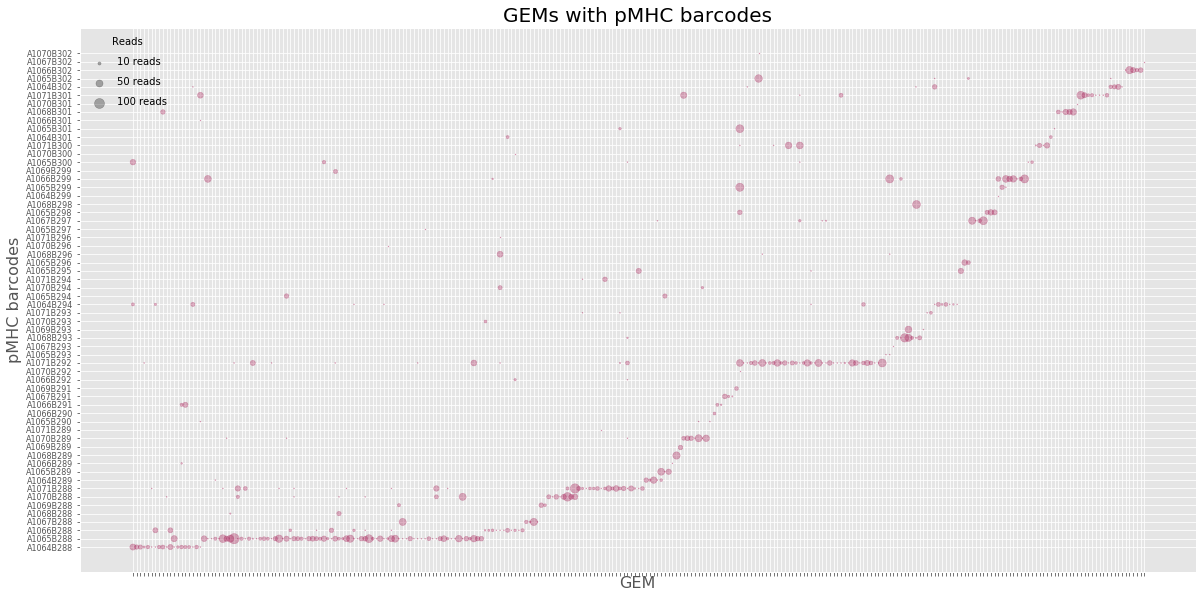

In [55]:
read_threshold = 10

all_clonotypes = tcr_df.raw_clonotype_id.unique()
num_clonotypes = len(all_clonotypes)

fig, ax = plt.subplots(figsize=(20, 10))

for mhc_barcode in mhc_barcode_ids: #specificity_df.columns:
    gems = specificity_df[specificity_df[mhc_barcode] > read_threshold].index
    mhcs = [mhc_barcode] * len(gems)
    reads = specificity_df.loc[gems, mhc_barcode].values
    
    clonotypes = np.array([gem_to_clonotype[gem] for gem in gems])
    
    none_indexes = np.where(clonotypes == 'None')

    gems = np.delete(gems, none_indexes)
    mhcs = np.delete(mhcs, none_indexes)
    reads = np.delete(reads, none_indexes)
    clonotypes = np.delete(clonotypes, none_indexes)

    #colors = [Paired(float(list(all_clonotypes).index(i))/num_clonotypes) for i in clonotypes]
    #colors = [clonotype_to_color[ct] for ct in clonotypes]
    colors = ['#9e0142'] * len(gems)
    
    scatter = ax.scatter(gems, mhcs, s=reads, c=colors, alpha=0.3, edgecolors='face')

plt.tick_params(labelbottom=False, labelsize=10) #8

## produce a legend with the unique colors from the scatter
#legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
#ax.add_artist(legend1)
#
## produce a legend with a cross section of sizes from the scatter
#handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
#legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")
##plt.legend([5, 10, 20], ["5", "10", "20"], loc="lower right", title="Sizes", prop="sizes")

from matplotlib.lines import Line2D

#legend_elements = []
#for clonotype_label in all_clonotypes:
#    #clonotype_color = Paired(float(list(all_clonotypes).index(clonotype_label))/num_clonotypes)
#    legend_elements += [Line2D([0], [0], marker='o', color='w', label=clonotype_label, markerfacecolor=clonotype_to_color[clonotype_label], markersize=10)]
#
#legend1 = ax.legend(handles=legend_elements)
#ax.add_artist(legend1)

for read_size in [10, 50, 100]:
    plt.scatter([], [], c='k', alpha=0.3, s=read_size, label=str(read_size) + ' reads')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Reads')

plt.xlabel("GEM", fontsize=16)
plt.ylabel("pMHC barcodes", fontsize=16)
plt.title("GEMs with pMHC barcodes (singlets removed)", fontsize=20)
plt.savefig(fig_dir + "GEMs_with_pMHC_barcodes_no_singlets.pdf")
plt.show()

In [49]:
specificity_df[(specificity_df > 0).any(1)].shape

(585, 135)

In [48]:
specificity_df[(specificity_df > read_threshold).any(1)].shape

(303, 135)

#  GEM plot validation

We are especially interested in A1071B292 and A1065B288 and A1069B293 mod A1068B293

In [21]:
A1071B292_gems = specificity_df[specificity_df.A1071B292 > read_threshold].index
A1071B292_clon = [gem_to_clonotype[gem] for gem in A1071B292_gems]
print(sorted(set(A1071B292_clon)))

['None', 'clonotype105', 'clonotype1474', 'clonotype15', 'clonotype1590', 'clonotype1591', 'clonotype1744', 'clonotype197', 'clonotype2', 'clonotype27', 'clonotype3', 'clonotype357', 'clonotype38', 'clonotype4', 'clonotype5', 'clonotype50', 'clonotype6']


In [22]:
A1065B288_gems = specificity_df[specificity_df.A1065B288 > read_threshold].index
A1065B288_clon = [gem_to_clonotype[gem] for gem in A1065B288_gems]
print(sorted(set(A1065B288_clon)))

['None', 'clonotype1', 'clonotype10', 'clonotype1101', 'clonotype1153', 'clonotype1396', 'clonotype1474', 'clonotype1712', 'clonotype178', 'clonotype18', 'clonotype1886', 'clonotype19', 'clonotype2', 'clonotype2268', 'clonotype2328', 'clonotype2486', 'clonotype2521', 'clonotype290', 'clonotype3', 'clonotype318', 'clonotype33', 'clonotype4', 'clonotype467', 'clonotype6', 'clonotype661']


In [129]:
A1064B301_gems = specificity_df[specificity_df.A1064B301 > 0].index
A1064B301_gems
tcr_df[tcr_df.barcode.isin(A1064B301_gems)].to_excel("/Volumes/tuba/herpov/tcr-pmhc-sc-project/tables/exp3/A1064B301_annotations.xlsx")

# Plot neoepitopes

In [113]:
read_threshold = 10

In [114]:
neoepitopes = [barcode for barcode in specificity_df.columns if barcode.endswith("B293")]

In [115]:
all_neoepitope_gems = list()
neoepitope_clon = dict()
for epitope in neoepitopes:
    neoepitope_gems = specificity_df[specificity_df[epitope] > read_threshold].index
    all_neoepitope_gems.append(neoepitope_gems)
    neoepitope_clon[epitope] = [gem_to_clonotype[gem] for gem in neoepitope_gems]

In [116]:
all_neoepitope_gems = [gem for gem_list in all_neoepitope_gems for gem in gem_list]
print(all_neoepitope_gems)

['CCTTCGAAGGACACCA-1', 'CATCAGACACCCTATC-1', 'CATATTCTCTTCCTTC-1', 'GCTGGGTAGGATGGAA-1', 'CTAGCCTTCAATACCG-1', 'TCGTACCTCTTTACAC-1', 'GCTGGGTAGGATGGAA-1', 'CTCTAATTCAATAAGG-1', 'TAGTGGTTCGCCGTGA-1', 'TCACAAGTCAGGCAAG-1', 'CTACACCCACGTCTCT-1', 'ATTATCCCAAACGCGA-1', 'CCTAAAGCACCCTATC-1', 'TTTGTCACACGACGAA-1']


In [117]:
tcr_df[tcr_df.barcode.isin(all_neoepitope_gems)].to_excel("/Volumes/tuba/herpov/tcr-pmhc-sc-project/tables/exp3/neoepitope_tcr_annotations_no_singlets.xlsx")

In [118]:
all_neoepitope_clones = list(set([clon for gem in neoepitope_clon.values() for clon in gem]))
print(len(all_neoepitope_clones))

5


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


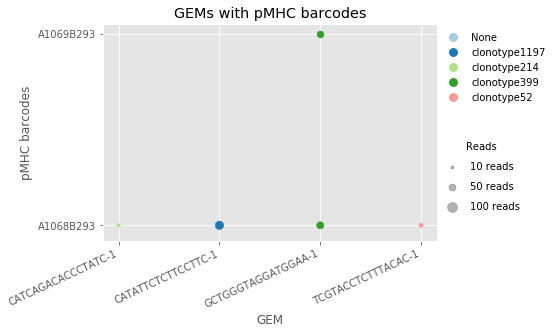

In [127]:
#read_threshold = 10

all_neoepitope_clones = sorted(list(set([clon for gem in neoepitope_clon.values() for clon in gem])))
num_clonotypes = len(all_neoepitope_clones)

col_clonotypes = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a'] #+ ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99']

clonotype_to_color = dict()
for i, clonotype in enumerate(all_neoepitope_clones):
    clonotype_to_color[clonotype] = col_clonotypes[i]

fig, ax = plt.subplots()

for mhc_barcode in specificity_df.columns:
    if not mhc_barcode.endswith("B293"):
        continue
    gems = specificity_df[specificity_df[mhc_barcode] > read_threshold].index
    mhcs = [mhc_barcode] * len(gems)
    reads = specificity_df.loc[gems, mhc_barcode].values
    
    clonotypes = np.array([gem_to_clonotype[gem] for gem in gems])
    
    none_indexes = np.where(clonotypes == 'None')

    gems = np.delete(gems, none_indexes)
    mhcs = np.delete(mhcs, none_indexes)
    reads = np.delete(reads, none_indexes)
    clonotypes = np.delete(clonotypes, none_indexes)
    colors = [clonotype_to_color[ct] for ct in clonotypes]
    
    scatter = ax.scatter(gems, mhcs, s=reads, c=colors)

#plt.tick_params(rotation=90) #labelbottom=False, labelsize=5
plt.xticks(rotation=25, ha='right') #, fontsize=7

from matplotlib.lines import Line2D

legend_elements = []
for clonotype_label in all_neoepitope_clones:
    #clonotype_color = Paired(float(list(all_clonotypes).index(clonotype_label))/num_clonotypes)
    legend_elements += [Line2D([0], [0], marker='o', color='w', label=clonotype_label, markerfacecolor=clonotype_to_color[clonotype_label], markersize=10)]

legend1 = ax.legend(handles=legend_elements, bbox_to_anchor=(1.35, 1.0), facecolor='w', edgecolor='w')
ax.add_artist(legend1)

for read_size in [10, 50, 100]:
    plt.scatter([], [], c='k', alpha=0.3, s=read_size, label=str(read_size) + ' reads')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Reads', bbox_to_anchor=(1.275, 0.5)) #  loc="lower right"

plt.xlabel("GEM")
plt.ylabel("pMHC barcodes")
plt.title("GEMs with pMHC barcodes")
#plt.tight_layout()
plt.savefig(fig_dir + "GEMs_with_pMHC_barcodes_neoepitopes_no_singlets.pdf", bbox_extra_artists=(legend1,), bbox_inches='tight') #_with_singlets
plt.show()

# GEM intersections

## TCR GEM barcodes

In [ ]:
tcr_gems_all = tcr_df.barcode.unique()
tcr_gems_is_cell = tcr_df[tcr_df.is_cell == True].barcode.unique()
tcr_gems_ready_for_use = np.loadtxt(tcr_filtered_gems_dir + "ready_for_use.lst", dtype=np.str)
tcr_gems_is_cell_paired_chains = set(tcr_gems_is_cell).intersection(set(tcr_gems_ready_for_use))

In [ ]:
print(len(tcr_gems_all))
print(len(tcr_gems_is_cell))
print(len(tcr_gems_ready_for_use))
print(len(tcr_gems_is_cell_paired_chains))

## Singlets

In [ ]:
mhc_barcode_gems = set(mhc_barcode_gems)
cd8_barcode_gems = set(cd8_barcode_gems)
tcr_gems_is_cell_paired_chains = set(tcr_gems_is_cell_paired_chains)

In [ ]:
mhc = len(set(mhc_barcode_gems))
cd8 = len(set(cd8_barcode_gems))
tcr = len(set(tcr_gems_is_cell_paired_chains))

In [ ]:
print(mhc)
print(cd8)
print(tcr)

In [ ]:
# Number of unique gems retrieved from Andreas parsing of reads.
specificity_df.shape[0]

## MHC-CD8 intersection

In [ ]:
mhc_cd8 = len(set(mhc_barcode_gems).intersection(set(cd8_barcode_gems)))

In [ ]:
print(mhc_cd8)

## MHC-TCR intersection

In [ ]:
mhc_tcr_all = set(mhc_barcode_gems).intersection(set(tcr_gems_all))
mhc_tcr_is_cell = set(mhc_barcode_gems).intersection(set(tcr_gems_is_cell))
mhc_tcr_ready_for_use = set(mhc_barcode_gems).intersection(set(tcr_gems_ready_for_use))
mhc_tcr_is_cell_paired_chains = set(mhc_barcode_gems).intersection(set(tcr_gems_is_cell_paired_chains))

In [ ]:
print(len(mhc_tcr_all))
print(len(mhc_tcr_is_cell))
print(len(mhc_tcr_ready_for_use))
print(len(mhc_tcr_is_cell_paired_chains))

In [ ]:
mhc_tcr = len(mhc_tcr_is_cell_paired_chains)

## TCR-CD8 intersection

In [ ]:
tcr_cd8 = len(set(cd8_barcode_gems).intersection(set(tcr_gems_is_cell_paired_chains)))

In [ ]:
print(tcr_cd8)

## MHC-TCR-CD8 intersection

In [ ]:
print(len(set(cd8_barcode_gems).intersection(mhc_tcr_all)))
print(len(set(cd8_barcode_gems).intersection(mhc_tcr_is_cell)))
print(len(set(cd8_barcode_gems).intersection(mhc_tcr_ready_for_use)))
print(len(set(cd8_barcode_gems).intersection(mhc_tcr_is_cell_paired_chains)))

In [ ]:
mhc_tcr_cd8 = len(set(cd8_barcode_gems).intersection(mhc_tcr_is_cell_paired_chains))

In [ ]:
g = mhc_tcr_cd8
c = mhc_tcr - g
e = mhc_cd8 - g
f = tcr_cd8 - g
a = len(mhc_barcode_gems) - c - e - g
b = len(tcr_gems_is_cell_paired_chains) - c - f - g
d = len(cd8_barcode_gems) - e - f - g

#a, b, c, d, e, f, g = 10, 8, 22, 6,9,4,2

In [ ]:
from matplotlib_venn import venn3
 
# Make the diagram
venn3(subsets = (a, b, c, d, e, f, g), set_labels = ('MHC', 'TCR', 'CD8'))
plt.savefig(fig_dir + "tcr-mhc-cd8_venn.pdf")
plt.show()
